In [1]:
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
import torch

import sys, os
from models.subpix_rcnn import SubpixRCNN
from utils import move_data_to_device, move_dict_to_cpu, plot_image_boxes, evaluate_predictions
from PsfSimulator import PsfDataset
from scripts.plotting import PlotController
from scripts.evaluating import test_model_fixed_snr, test_model_once_plot, evaluate_recall_per_snr


In [2]:
seed = None
num_datapoints = 100
num_spots_min = 3
num_spots_max = 8
sigma_mean= 1.0
sigma_std = 0.1
snr_min = 5
snr_max = 5
snr_std = 0.0
base_noise_min = 50
base_noise_max = 100
use_gauss_noise = False
gauss_noise_std = 0.02
use_perlin_noise = False
perlin_min_max = (0.4, 0.6)
img_w = 64
img_h = 64

dataset = PsfDataset(seed, num_datapoints, num_spots_min, num_spots_max, sigma_mean, sigma_std,
                      snr_min, snr_max, snr_std, base_noise_min, base_noise_max, use_gauss_noise,
                      gauss_noise_std, use_perlin_noise, perlin_min_max, img_w, img_h)



In [3]:
device = 'cuda'
backbone = resnet_fpn_backbone("resnet50", pretrained=True)
kwargs = {"nms_thresh": 0.1, "detections_per_img": None, "score_thresh": 0.8,}
model = SubpixRCNN(backbone, num_classes=2, device=device, **kwargs)
model.to(device=device)
path = r"D:\zeiss\Desktop\coding\Hilger\bachelor\subpix_rcnn_models\2025-05-22_18-47-47\first_long_run.pth"
model.load_state_dict(torch.load(path, map_location=device))
model.eval()

c:\Users\zeiss\anaconda3\envs\hilger312\Lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'backbone_name' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
c:\Users\zeiss\anaconda3\envs\hilger312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\zeiss\anaconda3\envs\hilger312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Custom SubpixRoIHeads successfully initialized!


SubpixRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [4]:
result = evaluate_recall_per_snr(model, 5000, device, 0.5)


In [5]:
import numpy as np
import matplotlib.pyplot as plt

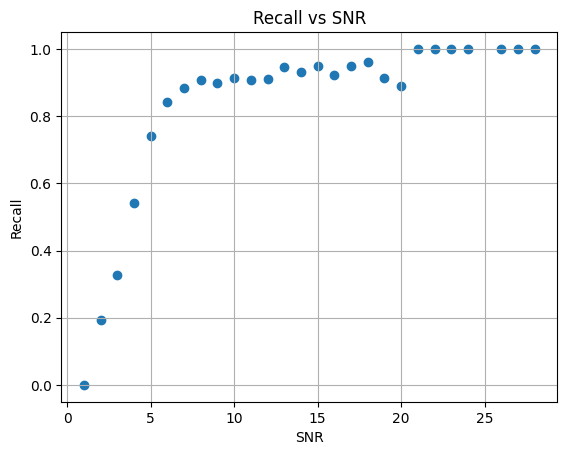

In [6]:
snrs = np.array(list(result.keys()))
recalls = np.array([result[snr]['TP'] / (result[snr]['TP'] + result[snr]['FN']) for snr in snrs])
plt.scatter(snrs, recalls)
plt.xlabel('SNR')
plt.ylabel('Recall')
plt.title('Recall vs SNR')
plt.grid()
plt.show()

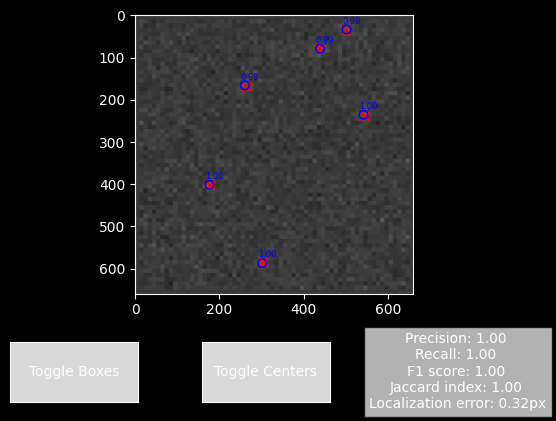

In [10]:
image, target = dataset[0]
image = move_data_to_device(image, device)
target = move_data_to_device(target, device)
model.eval()
with torch.no_grad():
    pred = model([image])
pred = pred[0]
pred = move_dict_to_cpu(pred)
target = move_dict_to_cpu(target)
PlotController(image, target, pred, 'eval', 1, 1, 1)

{'precision': 0.7058823529411765, 'recall': 0.6666666666666666, 'avg f1': 0.6857142857142857, 'avg ji': 0.5217391304347826, 'avg loc error': 0.3483467400074005}


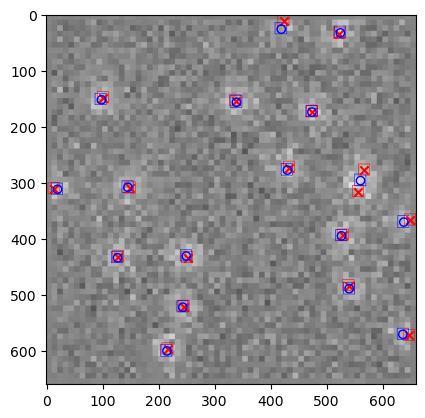

In [ ]:
test_model_once_plot(model, dataset, torch.device('cpu'),'simple')

In [ ]:
# THERE IS A PROBLEM WITH THE TARGET GENERATION
# When i use dataloader, target is a dict with batches..? So the dict elements are tensors with
# the wrong shape.

# WHAT SHOULD BE SIZE OF PSFS?

<class 'dict'>
<class 'dict'>


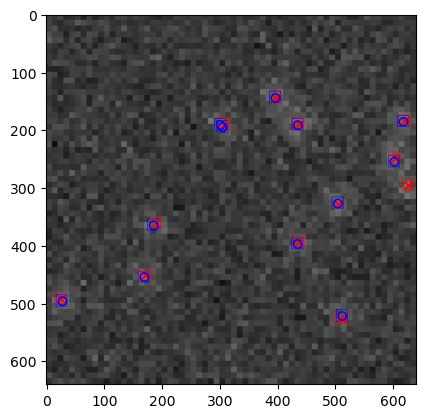

TypeError: string indices must be integers, not 'str'

In [11]:
dataloader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=0
)
device = torch.device('cpu')
model.eval()
for i, (image, target) in enumerate(dataloader):
    # Move data to device
    image = move_data_to_device(image, device)
    target = move_data_to_device(target, device)
    image = image.squeeze(0)
    target['boxes'] = target['boxes'].squeeze(0)
    target['positions'] = target['positions'].squeeze(0)
    # Run the model
    with torch.no_grad():
        predictions = model([image])
    # Plot the image and boxes
    print(type(predictions[0]))
    print(type(target))
    PlotController(image, target, predictions[0], type='image')
    # Evaluate the predictions
    evaluate_predictions(predictions, target)